In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


In [2]:
table_list = [] # list to store .xlsx files
for xlsx in os.listdir('nibrs'): # load nibrs excel files from folder
     table_list.append(pd.read_excel(f'nibrs//{xlsx}')) # add to list of tables

In [3]:
remove_formatting = ["State", "Agency Type", "Agency Name"] # columns to fix formatting

for tables in table_list:
    tables[remove_formatting] = (tables[remove_formatting]
    .apply(lambda x: x.str.replace(r'\d+', '', regex=True)) # remove subscript / superscript
    .apply(lambda x: x.str.strip()) # remove leading / trailing white space
    .fillna(method='ffill') # set na values caused by merged cells existing in xlsx files
    )

In [4]:
main_table = table_list[0] 
join_columns = list(main_table.columns[:3]) # columns we want to join by
pattern = '[^(Population)(Agency Type)]'    # select columns we don't want to include during regex search

for tables in table_list[1:]:
    main_table = main_table.merge(tables, on=join_columns, how='outer', suffixes = ['_x', '_y']) # merge tables on similar columns, always set suffix
    main_table['Population_x'] = round(np.mean(main_table.filter(regex=r'Population'), axis=1)) # find average of population
    sum_cols = np.add(                                                          # create column to hold summation of columns
                        main_table.filter(regex=rf'{pattern}.*_x$').fillna(0),  # select all columns (Total Offenses -> Crimes vs Society) with _x suffix
                        np.asarray(main_table.filter(regex=rf'{pattern}.*_y$')  # same as above except with _y suffix
                        .fillna(0)) # fill na values
                    )
    
    main_table[sum_cols.columns] = sum_cols # update columns

    main_table.drop(main_table.filter(regex=rf'_y$'), axis=1, inplace=True) # drop second set of columns created by the merge
    
    main_table.drop_duplicates(subset=join_columns, keep='last', ignore_index=True, inplace=True) # remove duplicate rows
    main_table.columns = main_table.columns.str.rstrip("_x")    # remove _x suiffix

In [5]:
def sum_Cities(main_table, state_list, column_titles):
    temp_table = dict()
    df = pd.DataFrame(columns=['State'])
    
    for col in column_titles:
        temp_table = dict()
        for state in state_list:
            sum = np.sum(main_table[col].loc[main_table['State'] == state])
            temp_table.update({state: sum})

        temp_df = pd.DataFrame.from_dict(temp_table, orient='index', columns=['Total State' + col])
        temp_df.reset_index(inplace=True)
        temp_df.columns = ['State', 'Statewide ' + col]
        df = df.merge(temp_df, how='outer')
    
    df.set_index('State')
    return df

# def calculate_proportions(main_table, statewide_count, state_list, column_titles):
#     proportions = pd.DataFrame(columns=['State'])

    # for col in column_titles:
        # proportions['Proportions\n' + col] = main_table[col] / ]
        

In [6]:

state_list = main_table['State'].unique()
statewide_count = sum_Cities(main_table, state_list, main_table.columns[4:8])


In [7]:

x = statewide_count.iloc[statewide_count.index[statewide_count['State'] == 'GEORGIA']]['Statewide Total\nOffenses']
print(int(x))

313830


In [8]:
test1 = lambda x: statewide_count['Statewide Total\nOffenses'].loc[x]


In [9]:
def calculate_proportions(row, category):

    row['Proportion of Crimes: ' + category] = np.divide(row[category] ,row['Total\nOffenses'])
    
    return row


In [10]:
for col in main_table.columns[5:8]:

    main_table = main_table.apply(calculate_proportions, category=col, axis=1)

main_table

C:\Users\pjame\AppData\Local\Temp/ipykernel_16916/210677289.py:3: RuntimeWarning: invalid value encountered in true_divide
  row['Proportion of Crimes: ' + category] = np.divide(row[category] ,row['Total\nOffenses'])
C:\Users\pjame\AppData\Local\Temp/ipykernel_16916/210677289.py:3: RuntimeWarning: divide by zero encountered in true_divide
  row['Proportion of Crimes: ' + category] = np.divide(row[category] ,row['Total\nOffenses'])


,State,Agency Type,Agency Name,Population,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Proportion of Crimes: Crimes\nAgainst\nPersons,Proportion of Crimes: Crimes\nAgainst\nProperty,Proportion of Crimes: Crimes\nAgainst\nSociety
0,ALABAMA,Cities,Hoover,85519.0,25324.0,5703.0,16818.0,4265.0,0.225201,0.664113,0.168417
1,ARIZONA,Cities,Apache Junction,42408.0,18573.0,4120.0,11349.0,4021.0,0.221827,0.611048,0.216497
2,ARIZONA,Cities,Gilbert,254700.0,91741.0,14115.0,55640.0,21986.0,0.153857,0.606490,0.239653
3,ARIZONA,Metropolitan Counties,Yuma,61017.0,24941.0,6101.0,18775.0,3686.0,0.244617,0.752777,0.147789
4,ARKANSAS,Cities,Alma,5850.0,5800.0,1909.0,3319.0,572.0,0.329138,0.572241,0.098621
...,...,...,...,...,...,...,...,...,...,...,...
10318,FEDERAL,Federal Agencies,"United States Department of Justice, Office of...",NaN,61.0,5.0,49.0,7.0,0.081967,0.803279,0.114754
10319,FEDERAL,Federal Agencies,"United States Election Assistance Commission, ...",NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
10320,FEDERAL,Federal Agencies,"United States Environmental Protection Agency,...",NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
10321,FEDERAL,Federal Agencies,United States Federal Deposit Insurance Corpor...,NaN,18.0,0.0,18.0,0.0,0.000000,1.000000,0.000000


In [11]:

statewide_comparisons = main_table.copy(deep=True)
remove_group = main_table.columns[8:8]

statewide_comparisons.drop(columns=remove_group)

,State,Agency Type,Agency Name,Proportion of Crimes: Crimes\nAgainst\nPersons,Proportion of Crimes: Crimes\nAgainst\nProperty,Proportion of Crimes: Crimes\nAgainst\nSociety
0,ALABAMA,Cities,Hoover,0.225201,0.664113,0.168417
1,ARIZONA,Cities,Apache Junction,0.221827,0.611048,0.216497
2,ARIZONA,Cities,Gilbert,0.153857,0.606490,0.239653
3,ARIZONA,Metropolitan Counties,Yuma,0.244617,0.752777,0.147789
4,ARKANSAS,Cities,Alma,0.329138,0.572241,0.098621
...,...,...,...,...,...,...
10318,FEDERAL,Federal Agencies,"United States Department of Justice, Office of...",0.081967,0.803279,0.114754
10319,FEDERAL,Federal Agencies,"United States Election Assistance Commission, ...",NaN,NaN,NaN
10320,FEDERAL,Federal Agencies,"United States Environmental Protection Agency,...",NaN,NaN,NaN
10321,FEDERAL,Federal Agencies,United States Federal Deposit Insurance Corpor...,0.000000,1.000000,0.000000


In [12]:
change_later = main_table.copy(deep=True)
remove_group = change_later.groupby(['State']).size().reset_index(name="Cities")
remove_group = remove_group['State'][remove_group['Cities'] < 30].tolist()

remove_group

['ALABAMA',
 'ARIZONA',
 'DISTRICT OF COLUMBIA',
 'FEDERAL',
 'HAWAII',
 'ILLINOIS',
 'MARYLAND',
 'NEVADA',
 'NEW MEXICO',
 'NEW YORK',
 'WYOMING']

In [13]:
state_crime_summary = change_later.copy(deep=True)
remove_group = state_crime_summary.columns[8:]
state_crime_summary = state_crime_summary.groupby(['State']).sum().reset_index()
state_crime_summary.drop(columns=remove_group, inplace=True)

for col in state_crime_summary.columns[3:]:
    calculate_proportions(state_crime_summary, category=col)

state_crime_summary

,State,Population,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Proportion of Crimes: Crimes\nAgainst\nPersons,Proportion of Crimes: Crimes\nAgainst\nProperty,Proportion of Crimes: Crimes\nAgainst\nSociety
0,ALABAMA,85519.0,25324.0,5703.0,16818.0,4265.0,0.225201,0.664113,0.168417
1,ARIZONA,1405311.0,252957.0,47905.0,157116.0,52474.0,0.189380,0.621117,0.207442
2,ARKANSAS,2084230.0,1989614.0,524066.0,1200761.0,276436.0,0.263401,0.603515,0.138940
3,COLORADO,4470248.0,2696448.0,485367.0,1917068.0,302802.0,0.180002,0.710960,0.112297
4,CONNECTICUT,3355701.0,962730.0,218604.0,622168.0,123812.0,0.227067,0.646254,0.128605
5,DELAWARE,298800.0,722675.0,168390.0,427165.0,127120.0,0.233009,0.591089,0.175902
6,DISTRICT OF COLUMBIA,0.0,32837.0,10471.0,17698.0,4668.0,0.318878,0.538965,0.142157
7,FEDERAL,0.0,1341.0,128.0,782.0,431.0,0.095451,0.583147,0.321402
8,GEORGIA,2552746.0,313830.0,88033.0,186955.0,38842.0,0.280512,0.595721,0.123768
9,HAWAII,978460.0,101524.0,20862.0,73786.0,6876.0,0.205488,0.726784,0.067728


In [14]:
def calculate_residuals(observed_table, expected_table,  category):
    observed_table['Residual: ' + category] = (observed_table[category] - (expected_table['Proportion of Crimes: ' + category] * expected_table['Total\nOffenses']) )**2 / (expected_table['Proportion of Crimes: ' + category] * expected_table['Total\nOffenses'])
    

In [15]:

copy_cols = state_crime_summary.columns[2:7]
national_statistics = np.sum(state_crime_summary[copy_cols])
national_statistics = national_statistics.to_frame().reset_index()
national_statistics.columns = [' ', 'Crime Count']
national_statistics = national_statistics.transpose()
national_statistics.columns = national_statistics.iloc[0]
national_statistics.reset_index(drop=True, inplace=True)
national_statistics.drop(national_statistics.index[0], inplace=True)
national_statistics.reset_index(drop=True)

for cols in national_statistics.columns[1:4]:
    national_statistics['Proportion of Crimes: ' + cols] = national_statistics[cols] / national_statistics['Total\nOffenses']

national_statistics

,Total\nOffenses,Crimes\nAgainst\nPersons,Crimes\nAgainst\nProperty,Crimes\nAgainst\nSociety,Proportion of Crimes: Crimes\nAgainst\nPersons,Proportion of Crimes: Crimes\nAgainst\nProperty,Proportion of Crimes: Crimes\nAgainst\nSociety
1,53172447.0,12795559.0,32917075.0,7862863.0,0.240643,0.619063,0.147875


In [16]:
test1 = main_table.copy(deep=True)  # copy main table so i don't have to keep running previous cells if there are changes
test1[[test1['Population'] == 0]] = np.NaN # set 0 population as NaN to prevent errors
test1['vs. Persons per Capita'] = np.where(test1['Population'] != np.nan, test1['Crimes\nAgainst\nPersons'] / test1['Population'], np.nan) # find per Capita values for populations values we have

persons = test1['vs. Persons per Capita'].loc[test1['vs. Persons per Capita'] >= 0] # create a series of all our per capita values
persons

0        0.066687
1        0.097151
2        0.055418
3        0.099989
4        0.326325
           ...   
10289    0.000198
10290    0.000066
10303    0.034507
10304    0.005478
10305    0.011055
Name: vs. Persons per Capita, Length: 6056, dtype: float64

0.12996615040432893
0.07070441261460259


(array([251.,  98.,  89.,  92.,  83.,  91.,  87.,  66.,  89.,  79.,  78.,
         79.,  71.,  83.,  71.,  67.,  71.,  56.,  64.,  61.,  68.,  53.,
         63.,  59.,  49.,  48.,  49.,  57.,  54.,  47.,  33.,  40.,  32.,
         51.,  41.,  37.,  37.,  39.,  35.,  41.,  39.,  39.,  39.,  28.,
         33.,  37.,  45.,  41.,  33.,  22.,  38.,  34.,  43.,  30.,  31.,
         30.,  24.,  27.,  31.,  37.,  34.,  42.,  33.,  28.,  22.,  26.,
         28.,  34.,  26.,  25.,  15.,  20.,  43.,  21.,  24.,  18.,  20.,
         29.,  23.,  26.,  20.,  30.,  20.,  28.,  25.,  22.,  17.,  19.,
         24.,  34.,  23.,  24.,  16.,  18.,  20.,  25.,  21.,  21.,  13.,
         21.,  17.,  16.,  11.,  18.,  15.,  22.,  16.,  20.,  15.,  22.,
         21.,  20.,  20.,  16.,  17.,  15.,  16.,  18.,  12.,  10.,  17.,
         15.,  12.,   8.,  13.,  18.,   9.,  17.,  13.,  11.,  15.,  16.,
          9.,  20.,   6.,  17.,   7.,  14.,  12.,  15.,  19.,   7.,  14.,
         10.,  16.,  16.,  10.,   9., 

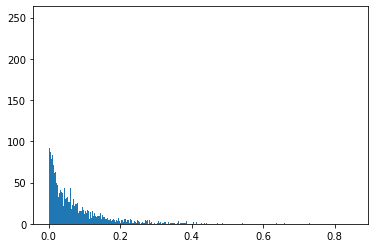

In [17]:
persons = test1['vs. Persons per Capita'].loc[test1['vs. Persons per Capita'] >= 0] # reset series in case it was changed by future code

std_persons = np.std(persons) # find std
mean_persons = np.mean(persons) # find mean
print(std_persons)
print(mean_persons)
graph_range = (0, mean_persons + 6*std_persons) # graph range so that we can better see the skewness. There are a few extreme outliers that would mess up the graphic.
plt.hist(persons, range=graph_range, bins=1000) # plot histogram

In [18]:
# log regression
# hierarchal model 
# sum of crimes, proportion of crimes that are committed  
find porportion of all the crimes in the sample
Proportion of person, prop, society

proportions for each agency type
# assume the null is True

    # of federal agency crimes, sample size N
# chi square: goodness of fit 


SyntaxError: invalid syntax (Temp/ipykernel_16916/3236149229.py, line 4)

(array([238., 243., 372., 492., 505., 486., 448., 445., 432., 402., 367.,
        316., 289., 253., 184., 155., 102.,  81.,  64.,  46.,  36.,  25.,
         24.,  17.,  11.,   7.,   6.,   1.,   1.,   2.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.02738613, 0.05477226, 0.08215838, 0.10954451,
        0.13693064, 0.16431677, 0.1917029 , 0.21908902, 0.24647515,
        0.27386128, 0.30124741, 0.32863353, 0.35601966, 0.38340579,
        0.41079192, 0.43817805, 0.46556417, 0.4929503 , 0.52033643,
        0.54772256, 0.57510869, 0.60249481, 0.

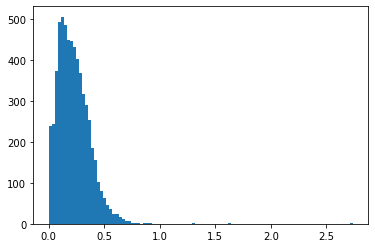

In [ ]:
persons = test1['vs. Persons per Capita'].loc[test1['vs. Persons per Capita'] >= 0] # reset series

persons = np.sqrt(persons) # apply sqrt function on our Per Capita values
std_persons = np.std(persons)
mean_persons = np.mean(persons)
graph_range = (0, mean_persons + 6*std_persons) # graph range so that we can better see the skewness. There are a few extreme outliers that would mess up the graphic.
plt.hist(persons, bins=100) # graph histogram

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,
          3.,   3.,   1.,   3.,   4.,   5.,   2.,   6.,   3.,   4.,  10.,
          7.,   8.,   9.,  13.,  11.,  15.,  17.,  21.,  21.,  24.,  31.,
         21.,  31.,  30.,  38.,  55.,  44.,  57.,  70.,  60.,  69.,  93.,
         92., 111., 117., 127., 142., 129., 160., 166., 158., 154., 175.,
        174., 188., 212., 207., 240., 228., 230., 240., 222., 239., 205.,
        231., 196., 162., 150., 108.,  84.,  74.,  49.,  42.,  31.,  25.,
         10.,   7.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-10.23676421, -10.11424754,  -9.99173087,  -9.8692142 ,
         -9.74669752,  -9.62418085,  -9.50166418,  -9.37914751,
         -9.25663083,  -9.13411416,  -9.01159749,  -8.88908082,
         -8.76656414,  -8.64404747,  -8.5215308 ,  -8.39901413,
         -8.27649746,  -8.15398078,  -8.03146411,  -7.90894744

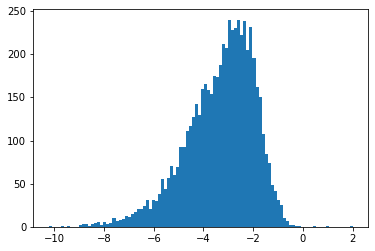

In [ ]:
persons = test1['vs. Persons per Capita'].loc[test1['vs. Persons per Capita'] > 0] # reset series

persons = np.log(persons) # apply log function on our per Capita values
plt.hist(persons, bins=100) # graph histogram

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,
          3.,   3.,   1.,   3.,   4.,   5.,   2.,   6.,   3.,   4.,  10.,
          7.,   8.,   9.,  13.,  11.,  15.,  17.,  21.,  21.,  24.,  31.,
         21.,  31.,  30.,  38.,  55.,  44.,  57.,  70.,  60.,  69.,  93.,
         92., 111., 117., 127., 142., 129., 160., 166., 158., 154., 175.,
        174., 188., 212., 207., 240., 228., 230., 240., 222., 239., 205.,
        231., 196., 162., 150., 108.,  84.,  74.,  49.,  42.,  31.,  25.,
         10.,   7.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-10.23676421, -10.11424754,  -9.99173087,  -9.8692142 ,
         -9.74669752,  -9.62418085,  -9.50166418,  -9.37914751,
         -9.25663083,  -9.13411416,  -9.01159749,  -8.88908082,
         -8.76656414,  -8.64404747,  -8.5215308 ,  -8.39901413,
         -8.27649746,  -8.15398078,  -8.03146411,  -7.90894744

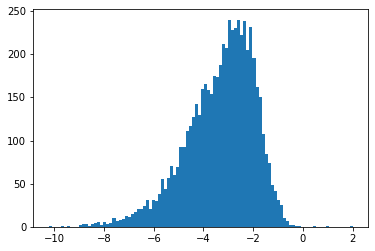

In [ ]:
zscore = (persons - np.mean(persons)) / np.std(persons) # create a series by using z score formula, (x - mu) / std
plt.hist(persons, bins=100)  # graphs results

In [ ]:
# used to store output of code

try:
    os.mkdir(f'{os.getcwd()}/nibrs_output') # make output folder
except FileExistsError:
    pass


In [ ]:
new_columns = ['State', 'Agency Type', 'Agency Name', 'Average Population (2012 - 2020)', 'Total Offenses', 'Crimes Against Persons', 'Crimes Against Property', 'Crimes Against Society'] # column names to save as
main_table.to_excel(f'{os.getcwd()}/nibrs_output/combined_nibrs_2012-2020.xlsx', na_rep='NA', sheet_name='Cities', header=new_columns, index=False) # store data in .xlsx
